# <span style="color:orange;">1.</span> Imports

## <span style="color:orange;">1.1.</span>  Libraries


In [28]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn import ensemble as en
from matplotlib import pyplot as plt


## <span style="color:orange;">1.2.</span>  Loas Data


In [2]:
df = pd.read_csv('../src/data/interim/train_processed_01.csv')

# <span style="color:orange;">2.</span>  Split Into Training and Test Set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'response'], df['response'], test_size=0.2, random_state=32)

# <span style="color:orange;">3.</span> Data Preparation

## <span style="color:orange;">3.1.</span> Rescaling

In [9]:
rs = RobustScaler()
mms = MinMaxScaler()

# age - MinMaxScaler
X_train.loc[:, 'age'] = mms.fit_transform(X_train[['age']])
X_test.loc[:, 'age'] = mms.transform(X_test[['age']])
pickle.dump(mms, open('../src/parameters/age_scaler.pkl', 'wb'))

# annual_premium - RobustScaler
X_train.loc[:, 'annual_premium'] = rs.fit_transform(X_train[['annual_premium']])
X_test.loc[:, 'annual_premium'] = rs.transform(X_test[['annual_premium']])
pickle.dump(rs, open('../src/parameters/annual_premium_scaler.pkl', 'wb'))

# vintage - MinMaxScaler
X_train.loc[:, 'vintage'] = mms.fit_transform(X_train[['vintage']])
X_test.loc[:, 'vintage'] = mms.transform(X_test[['vintage']])
pickle.dump(mms, open('../src/parameters/vintage_scaler.pkl', 'wb'))

# hi_customer_profitability - RobustScaler
X_train.loc[:, 'hi_customer_profitability'] = rs.fit_transform(X_train[['hi_customer_profitability']])
X_test.loc[:, 'hi_customer_profitability'] = rs.transform(X_test[['hi_customer_profitability']])
pickle.dump(rs, open('../src/parameters/hi_customer_profitability_scaler.pkl', 'wb'))

## <span style="color:orange;">3.2.</span> Encoding

In [10]:
# gender - One Hot Encoding
X_train['gender'] = X_train['gender'].map({'male': 1, 'female': 0})
X_test['gender'] = X_test['gender'].map({'male': 1, 'female': 0})

# region_code - Target Encoding
target_encode_region_code = pd.concat([X_train, y_train], axis=1).groupby('region_code')['response'].mean()
X_train['region_code'] = X_train['region_code'].map(target_encode_region_code)
X_test['region_code'] = X_test['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../src/parameters/region_code_scaler.pkl', 'wb'))

# vehicle_age - One Hot Encoding
X_train = pd.get_dummies(X_train, columns=['vehicle_age'], prefix='vehicle_age')
X_test = pd.get_dummies(X_test, columns=['vehicle_age'], prefix='vehicle_age')

# policy_sales_channel - Frequency Encoding
frequency_encode_sales_channel = X_train['policy_sales_channel'].value_counts(normalize=True)
X_train['policy_sales_channel'] = X_train['policy_sales_channel'].map(frequency_encode_sales_channel)
X_test['policy_sales_channel'] = X_test['policy_sales_channel'].map(frequency_encode_sales_channel)
pickle.dump(frequency_encode_sales_channel, open('../src/parameters/policy_sales_channel_scaler.pkl', 'wb'))

# age_binned - Frequency Encoding
frequency_encode_age_binned = X_train['age_binned'].value_counts(normalize=True)
X_train['age_binned'] = X_train['age_binned'].map(frequency_encode_age_binned)
X_test['age_binned'] = X_test['age_binned'].map(frequency_encode_age_binned)
pickle.dump(frequency_encode_age_binned, open('../src/parameters/age_binned_scaler.pkl', 'wb'))

# <span style="color:orange;">4.</span> Feature Selection

## <span style="color:orange;">4.</span> Feature Importance

In [21]:
# using ExtraTreesClassifier
model = en.ExtraTreesClassifier(n_estimators=250, random_state=32, n_jobs=-1)

# fit model
model.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=32)

,feature,importance
0,hi_customer_profitability,0.203147
1,vintage,0.194944
2,annual_premium,0.167985
3,age,0.104374
4,region_code,0.099139
5,vehicle_damage,0.065846
6,policy_sales_channel,0.062051
7,previously_insured,0.057547
8,age_binned,0.015496
9,vehicle_age_below_1_year,0.011694


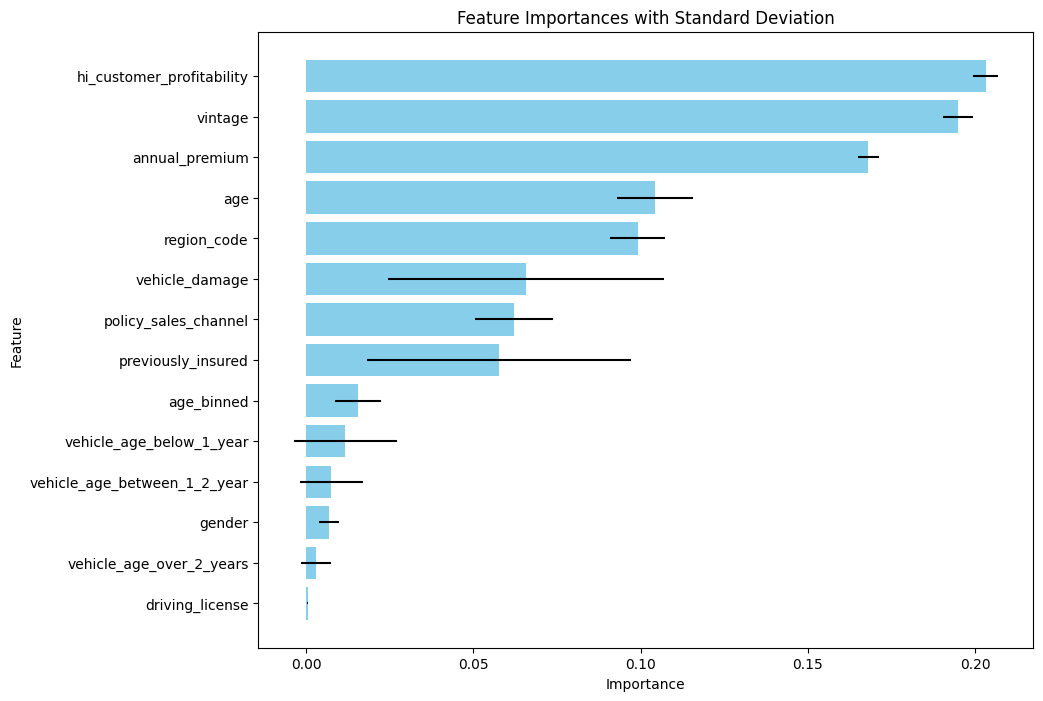

In [32]:
# show feature importances
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(feat_importances)[::-1]

# Creating a DataFrame with feature importances
df = pd.DataFrame({
    'feature': X_train.columns[indices],
    'importance': feat_importances[indices]
}).reset_index(drop=True)

display(df)

# plot the feature importance with std wit horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh( X_train.columns[indices], feat_importances[indices], xerr= std[indices], align='center', color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances with Standard Deviation')
plt.gca().invert_yaxis()  



In [34]:
col_selected =['hi_customer_profitability', 'vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel']

X_train = X_train[col_selected]
X_test = X_test[col_selected]

In [36]:
# save the new dataframes
X_train.to_csv('../src/data/interim/X_train_col_selected.csv', index=False)
X_test.to_csv('../src/data/interim/X_test_col_selected.csv', index=False)